# LAB 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib.collections import LineCollection

In [2]:
def simulate_particles(N, L, D, tau, F, dt, T_total):
    """
    Simulate a 2D random walk for N particles with given parameters.
    Parameters:
    N: number of particles
    L: box size (PBC)
    D: diffusion coefficient
    tau: correlation time of the noise
    F: force array of shape (N, 2)
    dt: time step
    T_total: total simulation time
    Returns:
    A dictionary with time array, MSD, correlation function, trajectory samples, and final positions.
    """
    num_steps = int(T_total / dt)
    
    # Initialize
    positions = np.random.uniform(0, L, (N, 2))
    positions_unwrapped = positions.copy()  # For MSD (no PBC)
    xi = np.random.normal(0, np.sqrt(D/tau), (N, 2))  # Colored noise
    
    # Store initial for MSD and correlation
    initial_positions = positions.copy()
    initial_xi = xi.copy()
    
    # Pre-generate white noise (optional - can generate on the fly)
    eta = np.random.normal(0, 1, (num_steps, N, 2))  # Shape: (steps, N, 2)
    
    # Results storage
    MSD = np.zeros(num_steps + 1)
    correlation = np.zeros(num_steps + 1)
    
    # Store trajectories for visualization (optional, sample steps)
    sample_steps = np.linspace(0, num_steps, min(1000, num_steps), dtype=int)
    trajectory_samples = []
    
    for step in range(num_steps):
        # Update Ornstein-Uhlenbeck process
        xi = xi - (xi/tau) * dt + np.sqrt(2*D/tau**2) * np.sqrt(dt) * eta[step] # Using Euler-Maruyama scheme
        
        # Update positions
        displacement = (F + xi) * dt 
        
        # With PBC (for next iteration)
        positions = (positions + displacement) % L
        
        # Without PBC (for MSD)
        positions_unwrapped = positions_unwrapped + displacement
        
        # Store MSD and correlation at every step
        MSD[step+1] = np.mean(np.sum((positions_unwrapped - initial_positions)**2, axis=1))
        
        # Correlation: E[ξ(t)·ξ(0)] (average over particles and components)
        correlation[step+1] = np.mean(np.sum(xi * initial_xi, axis=1))
        
        # Store sample of trajectory for plotting
        if step in sample_steps:
            trajectory_samples.append(positions.copy())
    
    # Time array
    time = np.arange(0, T_total + dt, dt)
    
    return {
        'time': time,
        'MSD': MSD,
        'correlation': correlation,
        'trajectory_samples': np.array(trajectory_samples),
        'final_positions': positions
    }

In [3]:
def simulate_particles_ex4(N, L, D, tau, f, epsilon, dt, T_total, realizations=10):
    """
    Simulate a 2D random walk for N particles with given parameters.
    
    Parameters:
    - N: number of particles
    - L: box size
    - D: diffusion coefficient
    - tau: correlation time
    - f: force magnitude (scalar)
    - epsilon: array of shape (N,) with +1 or -1 for each particle
    - dt: time step
    - T_total: total simulation time
    - realizations: number of independent noise realizations
    
    Returns dictionary with MSD_x and displacement_x averaged over realizations.
    """
    
    num_steps = int(T_total / dt)
    
    # Results storage
    MSD = np.zeros((num_steps + 1, realizations))
    displacement_x = np.zeros((num_steps + 1, realizations))
    
    # Pre-allocate trajectory samples (only for last realization if needed)
    sample_steps = np.linspace(0, num_steps, min(1000, num_steps), dtype=int)
    
    for rel in range(realizations):
        # Create force array - only in x-direction
        F = np.zeros((N, 2))
        F[:, 0] = f * epsilon  # Force in x-direction with sign from epsilon
        
        # Initialize
        positions = np.random.uniform(0, L, (N, 2))
        positions_unwrapped = positions.copy()  # For MSD (no PBC)
        xi = np.random.normal(0, np.sqrt(D/tau), (N, 2))  # Colored noise
        
        # Store initial positions
        initial_positions = positions.copy()
        
        # Pre-generate white noise for this realization
        eta = np.random.normal(0, 1, (num_steps, N, 2))
        
        # Store initial values
        MSD[0, rel] = 0.0
        displacement_x[0, rel] = 0.0
        
        # Temporary storage for trajectory samples (only for last realization)
        if rel == realizations - 1:  # Store only for the last realization
            trajectory_samples = []
        
        for step in range(num_steps):
            # Update Ornstein-Uhlenbeck process
            xi = xi - (xi/tau) * dt + np.sqrt(2*D/tau**2) * np.sqrt(dt) * eta[step]
            
            # Update positions
            displacement = (F + xi) * dt 
            
            # With PBC (for next iteration)
            positions = (positions + displacement) % L
            
            # Without PBC (for MSD and displacement calculation)
            positions_unwrapped = positions_unwrapped + displacement
            
            # Calculate MSD in x direction
            dx = positions_unwrapped[:, 0] - initial_positions[:, 0]
            MSD[step+1, rel] = np.mean(dx**2)
            
            # Calculate displacement_x weighted by epsilon: (1/N) Σ ε_i (x_i(t) - x_i(0))
            displacement_x[step+1, rel] = np.mean(epsilon * dx)
            
            # Store trajectory for plotting (only for last realization)
            if rel == realizations - 1 and step in sample_steps:
                trajectory_samples.append(positions.copy())
    
    # Average over realizations
    MSD_avg = np.mean(MSD, axis=1)
    MSD_std = np.std(MSD, axis=1)
    displacement_x_avg = np.mean(displacement_x, axis=1)
    displacement_x_std = np.std(displacement_x, axis=1)
    
    # Time array
    time = np.arange(0, T_total + dt, dt)
    
    return {
        'time': time,
        'MSD_x': MSD_avg,  # MSD along x direction
        'MSD_x_std': MSD_std,
        'displacement_x': displacement_x_avg,  # d_x(t) = (1/N) Σ ε_i ⟨x_i(t) - x_i(0)⟩
        'displacement_x_std': displacement_x_std,
        'trajectory_samples': np.array(trajectory_samples) if realizations > 0 else None,
        'F': F,  # For reference
        'epsilon': epsilon  # For reference
    }

In [4]:
def extract_mobility_diffusion(time, displacement_x, MSD_x, f, fit_fraction=0.3):
    """
    Extract μ and D from asymptotic slopes.
    
    Parameters:
    - time: time array
    - displacement_x: d_x(t) array
    - MSD_x: MSD along x array
    - f: force magnitude
    - fit_fraction: fraction of data to use for linear fit (from the end)
    
    Returns:
    - mu: mobility μ = lim_{t→∞} d_x(t)/(f*t)
    - D: diffusion coefficient D = lim_{t→∞} MSD_x(t)/(2t)
    """
    
    # Use only the last portion of data for fitting (asymptotic regime)
    n_fit = int(len(time) * fit_fraction)
    if n_fit < 10:  # Ensure at least 10 points
        n_fit = min(10, len(time))
    
    t_fit = time[-n_fit:]
    d_fit = displacement_x[-n_fit:]
    msd_fit = MSD_x[-n_fit:]
    
    # Fit line to displacement: d_x(t) = μ*f * t + const
    slope_d, _ = np.polyfit(t_fit, d_fit, 1)
    mu = slope_d / f
    
    # Fit line to MSD: MSD_x(t) = 2D * t + const
    slope_msd, _ = np.polyfit(t_fit, msd_fit, 1)
    D = slope_msd / 2
    
    return mu, D

def run_exercise5(N=1000, L=100, D0=1.0):
    """
    Main function for exercise 5.
    """
    
    # Simulation parameters
    tau_vals = np.logspace(0, 2, 100)  # Log-spaced from 1 to 100 (better than linear)
    f_vals = [ 0.01, 0.1, 1]
    
    # Generate epsilon once for consistency
    epsilon = np.random.choice([-1, 1], size=N)
    
    # Storage for results
    mu_results = {f: [] for f in f_vals}
    D_results = {f: [] for f in f_vals}
    
    # Run simulations
    for f in f_vals:
        print(f"\nProcessing f = {f}")
        
        for tau in tau_vals:
            # Adjust time parameters based on tau
            dt = 0.1  # Ensure dt << tau
            T_total = 1000 # Need long simulation for large tau
            
            # Run simulation
            results = simulate_particles_ex4(
                N=N, L=L, D=D0, tau=tau, f=f,
                epsilon=epsilon, dt=dt, T_total=T_total,
                realizations=5  # Can adjust based on time
            )
            
            # Extract μ and D from asymptotic slopes
            mu, D_eff = extract_mobility_diffusion(
                results['time'], 
                results['displacement_x'], 
                results['MSD_x'], 
                f
            )
            
            mu_results[f].append(mu)
            D_results[f].append(D_eff)
            
            print(f"  τ={tau:.1f}: μ={mu:.4f}, D={D_eff:.4f}")
    
    # Plot results
    plot_mobility_diffusion(tau_vals, mu_results, D_results, f_vals)
    
    return tau_vals, mu_results, D_results

def plot_mobility_diffusion(tau_vals, mu_results, D_results, f_vals):
    """
    Create publication-quality plots for μ(τ) and D(τ).
    """
    
    sns.set_theme(context="paper", style="ticks", font_scale=1.2)
    palette = sns.color_palette("colorblind", len(f_vals))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot A: Mobility μ vs τ
    ax1 = axes[0]
    for f, color in zip(f_vals, palette):
        ax1.plot(tau_vals, mu_results[f], 'o-', 
                markersize=5, linewidth=2, alpha=0.8,
                color=color, label=fr"$f={f}$")
    
    # Theoretical expectation: μ = 1 for overdamped Langevin (γ=1)
    ax1.axhline(y=1, color='black', linestyle='--', alpha=0.5, 
               linewidth=1, label=r'Theory: $\mu=1$')
    
    ax1.set_xlabel(r"Persistence time $\tau$", fontsize=14)
    ax1.set_ylabel(r"Mobility $\mu$", fontsize=14)
    ax1.set_xscale('log')
    ax1.legend(frameon=False, fontsize=10)
    ax1.grid(True, alpha=0.3, which='both')
    ax1.text(-0.15, 1.05, "(a)", transform=ax1.transAxes,
             fontsize=12, fontweight="bold", va="bottom")
    
    # Plot B: Diffusion coefficient D vs τ
    ax2 = axes[1]
    for f, color in zip(f_vals, palette):
        ax2.plot(tau_vals, D_results[f], 'o-', 
                markersize=5, linewidth=2, alpha=0.8,
                color=color, label=fr"$f={f}$")
    
    # Theoretical expectation for free particles (no force)
    ax2.axhline(y=1, color='black', linestyle='--', alpha=0.5,
               linewidth=1, label=r'Passive: $D=1$')
    
    ax2.set_xlabel(r"Persistence time $\tau$", fontsize=14)
    ax2.set_ylabel(r"Diffusion coefficient $D$", fontsize=14)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.legend(frameon=False, fontsize=10)
    ax2.grid(True, alpha=0.3, which='both')
    ax2.text(-0.15, 1.05, "(b)", transform=ax2.transAxes,
             fontsize=12, fontweight="bold", va="bottom")
    
    # Add text box with simulation parameters
    param_text = f'$N={1000}$\n$L={500}$\n$D_0={1.0}$'
    fig.text(0.02, 0.98, param_text, transform=fig.transFigure,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig("mobility_diffusion_force_corrected.pdf", dpi=300, 
                bbox_inches="tight", transparent=False)
    print("Figure saved to mobility_diffusion_force_corrected.pdf")
    plt.show()


## Exercise 1

Figure saved to trajectories_tau1.pdf


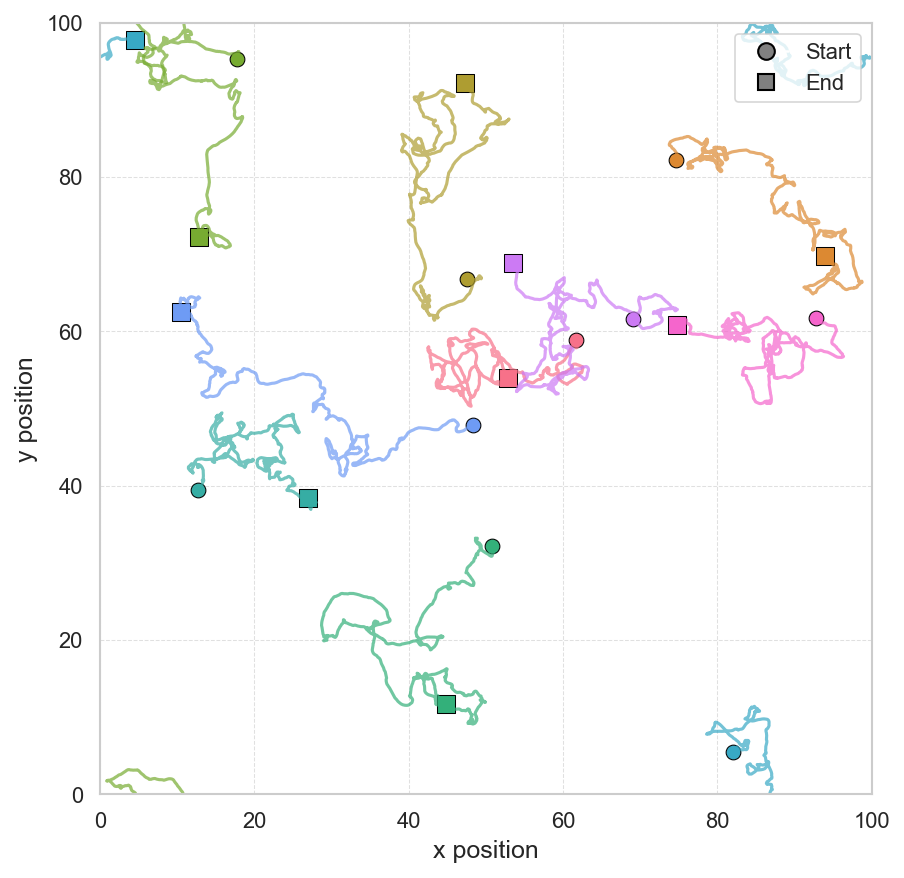

In [5]:
N = 1000 # big enough for reliable results, not too big to be slow
D = 1 # Diffusion coefficient
tau = 1
L = 100 # Lenght both in x and y direction (Change it!)
F = np.zeros((N, 2)) # No external force
dt = tau / 10 # Time step
T_total = 100 * tau # Total simulation time
max_particles_to_plot = 10 # Number of particle trajectories to plot
save_path = "trajectories_tau1.pdf"

# Plot trajectories 
results = simulate_particles(N, L, D, tau, F, dt, T_total)
time = results['time']
trajectory_samples = results['trajectory_samples']


# Generate trajectory plot
sns.set_theme(
    context="paper",
    style="ticks",
    font_scale=1.2
)
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

# Create figure with specific dimensions
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
    
# Get trajectory samples
trajectory_samples = results['trajectory_samples']
    
# Limit to specified number of particles
num_particles = min(max_particles_to_plot, trajectory_samples.shape[1])
    
# Create a color palette
colors = sns.color_palette("husl", n_colors=num_particles)
    
# Plot each particle trajectory WITHOUT connecting jumps
for i in range(num_particles):
    # Get trajectory for particle i
    traj = trajectory_samples[:, i, :]  # Shape: (time_points, 2)
        
    # Find jumps where particle wraps around (displacement > L/2)
    diff = np.diff(traj, axis=0)
    jump_indices = np.where(np.any(np.abs(diff) > L/2, axis=1))[0]
        
    # Create segments separated at jump points
    segments = []
    start_idx = 0
    for jump_idx in jump_indices:
        segments.append(traj[start_idx:jump_idx+1])
        start_idx = jump_idx + 1
    segments.append(traj[start_idx:])
        
    # Plot each segment
    for seg in segments:
        if len(seg) > 1:  # Only plot if segment has at least 2 points
            ax.plot(seg[:, 0], seg[:, 1], color=colors[i], alpha=0.7, linewidth=1.5)
        
    # Add a marker at the starting point
    ax.scatter(traj[0, 0], traj[0, 1], color=colors[i], s=50, 
                marker='o', edgecolor='black', linewidth=0.5, label=f'Particle {i+1}' if i < 5 else None)
        
    # Add a marker at the ending point
    ax.scatter(traj[-1, 0], traj[-1, 1], color=colors[i], s=70, 
                marker='s', edgecolor='black', linewidth=0.5)
    
# Set limits and aspect ratio
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_aspect('equal')
    
# Add labels with proper formatting
ax.set_xlabel('x position', fontsize=12)
ax.set_ylabel('y position', fontsize=12)
    
               
    
# Add grid
ax.grid(True, linestyle='--', alpha=0.6, linewidth=0.5)
    
# Add legend (only for first 5 particles to avoid clutter)

# Add a custom legend for start/end markers
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Start',
            markerfacecolor='gray', markersize=8, markeredgecolor='black'),
    Line2D([0], [0], marker='s', color='w', label='End',
            markerfacecolor='gray', markersize=8, markeredgecolor='black')
]
ax.legend(handles=legend_elements, loc='upper right')
    

    
# Tight layout
plt.tight_layout()
    
# Save 
plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
print(f"Figure saved to {save_path}")
    
plt.show()


## Exercise 2


Figure saved to MSD_noforce_avg10.pdf


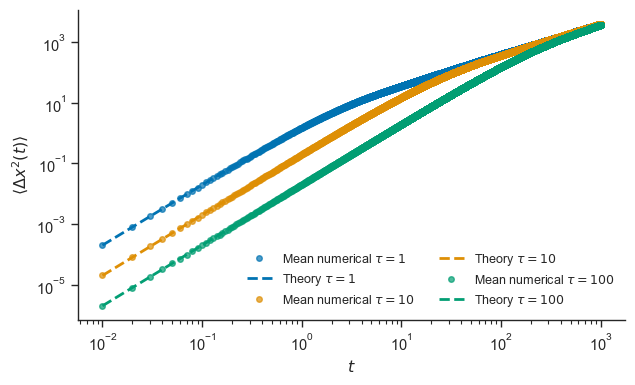

In [6]:
tau_vals = [1, 10, 100]  # Different time constants to simulate
n_runs = 10  # Number of independent simulations to average
save_path = 'MSD_noforce_avg10.pdf'

# Compute MSD across runs and aggregate
results_msd_mean = {}

time = None
for tau in tau_vals:
    dt = 0.01  # Time step
    T_total = 1000  # Total simulation time
    msd_runs = []
    for r in range(n_runs):
        res = simulate_particles(N, L, D, tau, F, dt, T_total)
        msd_runs.append(res['MSD'])
        if time is None:
            time = res['time']
    msd_runs = np.vstack(msd_runs)
    results_msd_mean[tau] = msd_runs.mean(axis=0)
# Theoretical MSD
def theoretical_MSD(t, D, tau):
    return 4 * D * (t - tau * (1 - np.exp(-t / tau)))

# Plotting results
sns.set_theme(context="paper", style="ticks", font_scale=1.2)
palette = sns.color_palette("colorblind", len(tau_vals))

plt.figure(figsize=(6.5, 4))

# Exclude t=0 so log-scale has no zeros
tmask = time > 0
t_plot = time[tmask]

for tau, color in zip(tau_vals, palette):
    mean = results_msd_mean[tau][tmask]
    # Mean curve
    plt.plot(
        t_plot,
        mean,
        'o',
        markersize=4,
        alpha=0.7,
        linewidth=2,
        color=color,
        label=fr"Mean numerical $\tau={tau}$"
    )
    # Theory
    plt.plot(
        t_plot,
        theoretical_MSD(t_plot, D, tau),
        linestyle='--',
        linewidth=2,
        color=color,
        label=fr"Theory $\tau={tau}$"
    )

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"$t$")
plt.ylabel(r"$\langle \Delta x^2(t) \rangle$")

plt.legend(
    frameon=False,
    fontsize=9,
    ncol=2
)

sns.despine()
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=False)
print(f"Figure saved to {save_path}")
plt.show()


## Exercise 3

Figure saved to correlation_noforce_avg10.pdf


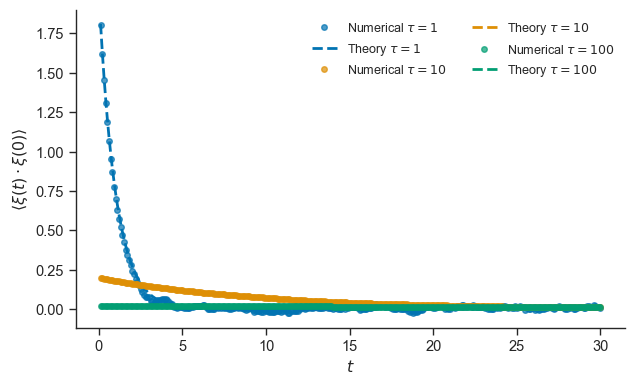

In [7]:
tau_vals = [1, 10, 100]  # Different time constants to simulate
n_runs = 10  # Number of independent simulations to average
save_path = 'correlation_noforce_avg10.pdf'

# Compute correlation across runs and aggregate
results_corr_mean = {}
results_corr_std = {}

time = None
for tau in tau_vals:
    dt = 0.1  # Time step
    T_total = 30  # Total simulation time
    corr_runs = []
    for r in range(n_runs):
        res = simulate_particles(N, L, D, tau, F, dt, T_total)
        corr_runs.append(res['correlation'])
        if time is None:
            time = res['time']
    corr_runs = np.vstack(corr_runs)
    results_corr_mean[tau] = corr_runs.mean(axis=0)
    results_corr_std[tau] = corr_runs.std(axis=0)

# Theoretical Correlation
def theoretical_correlation(t, D, tau):
    return (2 * D / tau) * np.exp(-t / tau)

# Plotting results
sns.set_theme(context="paper", style="ticks", font_scale=1.2)
palette = sns.color_palette("colorblind", len(tau_vals))
plt.figure(figsize=(6.5, 4))

# Exclude t=0
mask = time > 0
t_plot = time[mask]
for tau, color in zip(tau_vals, palette):
    mean = results_corr_mean[tau][mask]
    std = results_corr_std[tau][mask]
    # Mean curve
    plt.plot(
        t_plot,
        mean,
        'o',
        markersize=4,
        alpha=0.7,
        linewidth=2,
        color=color,
        label=fr"Numerical $\tau={tau}$"
    )
    plt.plot(
        t_plot,
        theoretical_correlation(t_plot, D, tau),
        linestyle='--',
        linewidth=2,
        color=color,
        label=fr"Theory $\tau={tau}$"
    )
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle \xi(t) \cdot \xi(0) \rangle$")
plt.legend(
    frameon=False,
    fontsize=9,
    ncol=2
)   
sns.despine()
plt.tight_layout()
plt.savefig(save_path, dpi=300, bbox_inches='tight',
            transparent=False)
print(f"Figure saved to {save_path}")
plt.show()

## Exercise 4

Figure saved to MSD_displacement_force_avg10.pdf


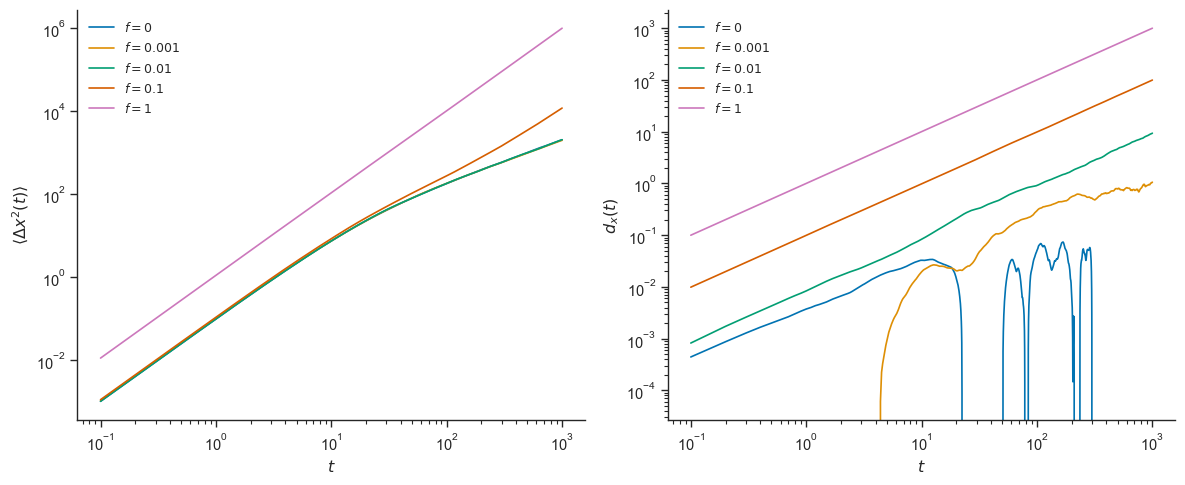

In [8]:
# Design a force field
epsilon = np.random.choice([-1, 1], size=(N,1))
f_vals = [0, 0.001, 0.01, 0.1, 1]
realizations = 10  # average over 10 independent runs
MSD_x_all = {}
displacement_x_all = {}
for f in f_vals:
    Fx = epsilon * f
    Fy = np.zeros((N,1))
    F = np.hstack((Fx, Fy))
    tau = 10
    dt = 0.1 # Time step
    T_total = 1000  # Total simulation time
    results = simulate_particles_ex4(N, L, D, tau, f, epsilon.flatten(), dt, T_total, realizations=realizations)
    time = results['time']
    # MSD along x direction
    MSD_x = results['MSD_x']
    # Displacement along x direction
    disp_x = results['displacement_x']

    MSD_x_all[f] = MSD_x
    displacement_x_all[f] = disp_x

# Plotting results
sns.set_theme(context="paper", style="ticks", font_scale=1.2)
palette = sns.color_palette("colorblind", len(f_vals))
plt.figure(figsize=(12, 5))

# Exclude t=0 to avoid zeros in log-scale
tmask = time > 0
t_plot = time[tmask]

# MSD plot
plt.subplot(1, 2, 1)
for f, color in zip(f_vals, palette):
    plt.plot(
        t_plot,
        MSD_x_all[f][tmask],
        label=fr"$f={f}$",
        color=color
    )
plt.xlabel(r"$t$")
plt.ylabel(r"$\langle \Delta x^2(t) \rangle$")
plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False, fontsize=9)
# Displacement plot
plt.subplot(1, 2, 2)
for f, color in zip(f_vals, palette):
    plt.plot(
        t_plot,
        displacement_x_all[f][tmask],
        label=fr"$f={f}$",
        color=color
    )
plt.xlabel(r"$t$")
plt.ylabel(r"$d_x(t)$")
plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False, fontsize=9)
sns.despine()
plt.tight_layout()
plt.savefig('MSD_displacement_force_avg10.pdf', dpi=300, bbox_inches='tight',
            transparent=False)
print("Figure saved to MSD_displacement_force_avg10.pdf")
plt.show()


## Exercise 5


Processing f = 0.01
  τ=1.0: μ=1.1783, D=1.1185
  τ=1.0: μ=1.0357, D=1.0835
  τ=1.1: μ=0.8718, D=1.0893
  τ=1.1: μ=1.0354, D=1.0447
  τ=1.2: μ=1.1621, D=1.0900
  τ=1.3: μ=0.9628, D=1.0428
  τ=1.3: μ=1.0238, D=1.0597
  τ=1.4: μ=0.9697, D=1.0381
  τ=1.5: μ=0.9868, D=1.0940
  τ=1.5: μ=1.1507, D=1.1537
  τ=1.6: μ=1.0352, D=1.0728
  τ=1.7: μ=1.1302, D=1.0469
  τ=1.7: μ=0.7167, D=0.9568
  τ=1.8: μ=0.9603, D=1.0638
  τ=1.9: μ=0.9440, D=1.1413
  τ=2.0: μ=0.9440, D=1.0972
  τ=2.1: μ=0.8223, D=1.0262
  τ=2.2: μ=1.0150, D=1.0761
  τ=2.3: μ=0.8600, D=1.1184
  τ=2.4: μ=0.8758, D=1.1438
  τ=2.5: μ=1.0431, D=1.1034
  τ=2.7: μ=1.0057, D=1.1392
  τ=2.8: μ=1.0183, D=1.0975
  τ=2.9: μ=0.8609, D=1.0131
  τ=3.1: μ=0.8593, D=1.0302
  τ=3.2: μ=1.0801, D=1.0261
  τ=3.4: μ=0.8681, D=1.0798
  τ=3.5: μ=1.1672, D=1.1143
  τ=3.7: μ=1.2554, D=1.1397
  τ=3.9: μ=1.1708, D=1.0690
  τ=4.0: μ=1.0337, D=1.0317
  τ=4.2: μ=1.1074, D=1.1312
  τ=4.4: μ=0.9041, D=1.0326
  τ=4.6: μ=0.8778, D=1.0581
  τ=4.9: μ=1.1368, D=1.0813

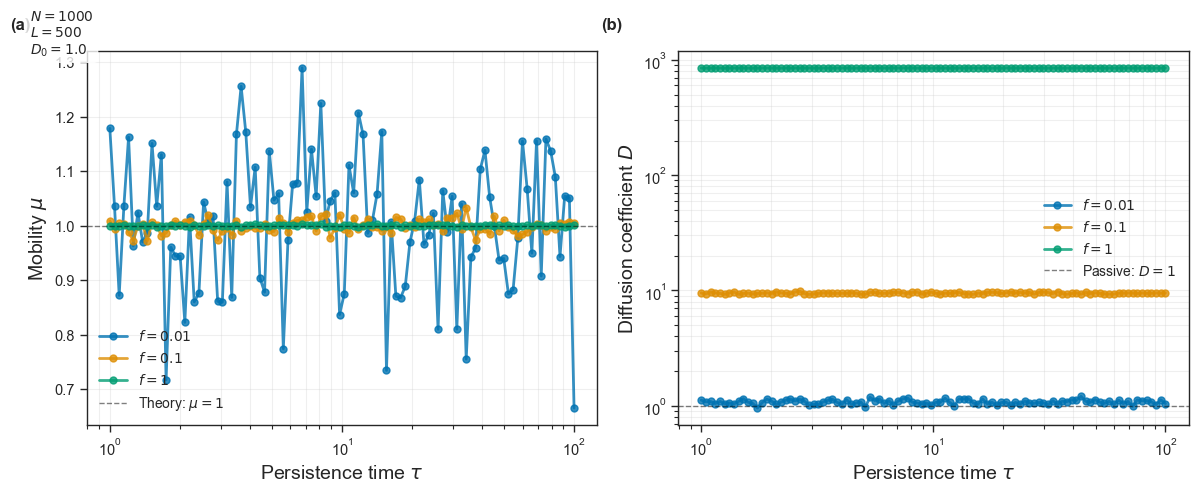

In [9]:
tau_vals, mu_results, D_results = run_exercise5()